In [ ]:
#| default_exp framedimensions
#| export
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class FramingDimensions:
    def __init__(self, base_model, dimensions, pole_names):
        self.encoder = SentenceTransformer(base_model)
        self.dimensions = dimensions
        self.dim_embs = self.encoder.encode(dimensions)
        self.pole_names = pole_names
        self.axis_names = list(map(lambda x: x[0] + "/" + x[1], pole_names))
        axis_embs = []
        for pole1, pole2 in pole_names:
            p1 = self.get_dimension_names().index(pole1)
            p2 = self.get_dimension_names().index(pole2)
            axis_emb = self.dim_embs[p1] - self.dim_embs[p2]
            axis_embs.append(axis_emb)
        self.axis_embs = np.stack(axis_embs)

    def get_dimension_names(self):
        dimension_names = [l.split(":")[0].split(" ")[0] for l in self.dimensions]
        return dimension_names

    def __call__(self, sequence_to_align):
        embs = self.encoder.encode(sequence_to_align)
        scores = embs @ self.axis_embs.T
        named_scores = dict(zip(self.pole_names, scores.T))
        return named_scores

    def visualize(self, align_scores_df, **kwargs):
        name_left = align_scores_df.columns.map(lambda x: x[1])
        name_right = align_scores_df.columns.map(lambda x: x[0])
        bias = align_scores_df.mean()
        color = ["b" if x > 0 else "r" for x in bias]
        inten = (align_scores_df.var().fillna(0)+0.001)*50_000
        bounds = bias.abs().max()*1.1

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.scatter(x=bias, y=name_left, s=inten, c=color)
        plt.axvline(0)
        plt.xlim(-bounds, bounds)
        plt.gca().invert_yaxis()
        axi = ax.twinx()
        axi.set_ylim(ax.get_ylim())
        axi.set_yticks(ax.get_yticks(), labels=name_right)
        plt.tight_layout()
        return fig

In [ ]:
base_model = 'all-mpnet-base-v2'
dimensions = [
    "Care: ...acted with kindness, compassion, or empathy, or nurtured another person.",
    "Harm: ...acted with cruelty, or hurt or harmed another person/animal and caused suffering.",
    "Fairness: ...acted in a fair manner, promoting equality, justice, or rights.",
    "Cheating: ...was unfair or cheated, or caused an injustice or engaged in fraud.",
    "Loyalty: ...acted with fidelity, or as a team player, or was loyal or patriotic.",
    "Betrayal: ...acted disloyal, betrayed someone, was disloyal, or was a traitor.",
    "Authority: ...obeyed, or acted with respect for authority or tradition.",
    "Subversion: ...disobeyed or showed disrespect, or engaged in subversion or caused chaos.",
    "Sanctity: ...acted in a way that was wholesome or sacred, or displayed purity or sanctity.",
    "Degredation: ...was depraved, degrading, impure, or unnatural.",
]
pole_names = [
    ("Care", "Harm"), 
    ("Fairness", "Cheating"),
    ("Loyalty", "Betrayal"),
    ("Authority", "Subversion"),
    ("Sanctity", "Degredation"),
]

example_list = ["In 2010, CFCs were banned internationally due to their harmful effect on the ozone layer.",
                "In 2021, doctors prevented the spread of the virus by vaccinating with Pfizer.",
                "We must fight for our freedom.",
                "The government prevents our freedom.",
                "They prevent the spread.",
                "We fight the virus.",
                "I believe that we should act now.\nThere is no time to waste.",
                ]

framing_dimen_model = FramingDimensions(base_model, dimensions, pole_names)
assert type(framing_dimen_model(example_list[0])) == dict
assert type(framing_dimen_model(example_list)) == dict
test_dimens = framing_dimen_model(example_list)
test_dimens

{('Care',
  'Harm'): array([-0.15387589,  0.10037182, -0.06937939, -0.16903251, -0.0124326 ,
         0.10496716,  0.09917428], dtype=float32),
 ('Fairness',
  'Cheating'): array([-0.10247803,  0.03238375,  0.09528822,  0.06894703,  0.05423794,
        -0.00429548,  0.06256694], dtype=float32),
 ('Loyalty',
  'Betrayal'): array([-0.03953579,  0.08804406,  0.03784094, -0.05983147,  0.04533485,
         0.06750815, -0.03902258], dtype=float32),
 ('Authority',
  'Subversion'): array([-0.07708085, -0.04315241, -0.05131513, -0.00762892,  0.08650668,
        -0.09983855,  0.05713998], dtype=float32),
 ('Sanctity',
  'Degredation'): array([-0.12603989,  0.06127246,  0.05510061, -0.06018388,  0.00770774,
         0.01998245,  0.05198321], dtype=float32)}

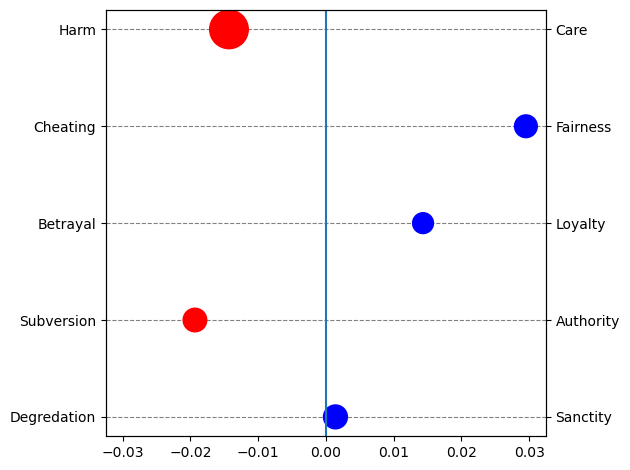

In [ ]:
test_dimens_df = pd.DataFrame(test_dimens)
g = framing_dimen_model.visualize(test_dimens_df);
g.axes[0].set_axisbelow(True)
g.axes[0].yaxis.grid(color='gray', linestyle='dashed')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()